This notebook aims to check the TROPOMI cloud pressure and tropopause pressure over lightning pixels.

In [1]:
import proplot as pplt
import numpy as np
import xarray as xr
from xhistogram.xarray import histogram
from matplotlib.ticker import PercentFormatter

## Read lightning pixel data

In [2]:
ds_swath_70 = xr.open_mfdataset('../data/swath_lightning_crf70*.nc', concat_dim='time', combine='nested')
ds_swath_70 = ds_swath_70.where((ds_swath_70['lightning_counts']>100)&(ds_swath_70['delta']>-100))

In [3]:
ds_swath_70

<xarray.Dataset>
Dimensions:           (time: 3909, longitude: 720, latitude: 60)
Coordinates:
  * longitude         (longitude) float64 -179.8 -179.2 -178.8 ... 179.2 179.8
  * latitude          (latitude) float64 60.25 60.75 61.25 ... 88.75 89.25 89.75
  * time              (time) datetime64[ns] 2019-06-01T02:27:14.659215 ... 20...
Data variables:
    lightning_counts  (time, longitude, latitude) float64 dask.array<chunksize=(1301, 720, 60), meta=np.ndarray>
    delta             (time, longitude, latitude) float64 dask.array<chunksize=(1301, 720, 60), meta=np.ndarray>
    no2_geo           (time, longitude, latitude) float64 dask.array<chunksize=(1301, 720, 60), meta=np.ndarray>
    sza               (time, longitude, latitude) float64 dask.array<chunksize=(1301, 720, 60), meta=np.ndarray>
    pcld              (time, longitude, latitude) float64 dask.array<chunksize=(1301, 720, 60), meta=np.ndarray>
    ptropo            (time, longitude, latitude) float64 dask.array<chunksize=(1301, 720, 60), meta=np.ndarray>

## Check the percentage for each cloud pressure bin

In [4]:
bin_ptropo = np.arange(160, 280, 20)
# bin_pcld = np.arange(150, 650, 50)
# bin_pcld = np.arange(100, 650, 50)
bin_pcld = np.arange(100, 950, 50)
# bin_ptropo = np.arange(200, 350, 50)
# bin_pcld = np.arange(200, 350, 50)

ptropo_center = np.convolve(bin_ptropo, np.ones(2), 'valid') / 2
pcld_center = np.convolve(bin_pcld, np.ones(2), 'valid') / 2

# https://github.com/xgcm/xhistogram/issues/16#issuecomment-1167271530
hts = histogram(ds_swath_70['pcld'], ds_swath_70['ptropo'], bins=[bin_pcld, bin_ptropo], dim=['longitude', 'latitude']).sum(dim='time')

In [5]:
# total data counts in bins
ptropo_bin_counts = np.count_nonzero(~np.isnan(ds_swath_70['ptropo']))
pcld_bin_counts = np.count_nonzero(~np.isnan(ds_swath_70['pcld']))

In [9]:
hts.load()

<xarray.DataArray 'histogram_pcld_ptropo' (pcld_bin: 16, ptropo_bin: 5)>
array([[ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0, 17,  0,  1,  0],
       [ 0, 43,  1,  2,  0],
       [ 0, 46,  4,  4,  0],
       [ 0, 29,  3,  8,  6],
       [ 0, 29,  1,  8,  4],
       [ 0, 15,  0,  3,  1],
       [ 0, 16,  1,  6,  1],
       [ 0,  3,  0,  2,  1],
       [ 0,  2,  0,  3,  0],
       [ 0,  2,  0,  3,  0],
       [ 0,  1,  0,  2,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  2,  0,  0,  1],
       [ 0,  0,  0,  0,  0]])
Coordinates:
  * pcld_bin    (pcld_bin) float64 125.0 175.0 225.0 275.0 ... 775.0 825.0 875.0
  * ptropo_bin  (ptropo_bin) float64 170.0 190.0 210.0 230.0 250.0

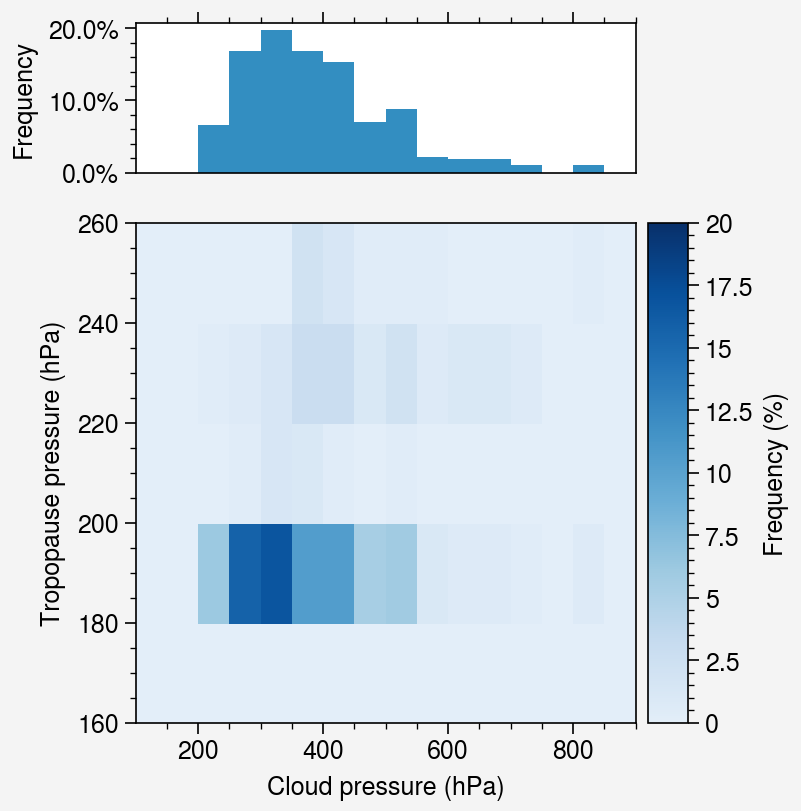

In [14]:
fig, axs = pplt.subplots()

(hts/ptropo_bin_counts*100).plot(x='pcld_bin', ax=axs, vmin=0, vmax=20, discrete=False, cmap='Blues',
                          cbar_kwargs=dict(label='Frequency (%)'),
                          cmap_kw={'left': 0.1})


ax = axs.panel(side='t', space=2, width='6em')
ds_swath_70['pcld'].plot.hist(ax=ax, bins=np.arange(100, 950, 50), weights=np.ones(pcld_bin_counts) / pcld_bin_counts, alpha = 0.8)
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.format(grid=False, xlabel='Cloud pressure (hPa)', ylabel='Frequency', xlim=(100, 900))


axs.format(grid=False, ylabel='Tropopause pressure (hPa)', xlabel='Cloud pressure (hPa)')

fig.savefig('../figures/pcld_ptropo.pdf')